# Notebook 1: Project Overview, Data Import, EDA
# Author: Will Wu

---

## **Table of Contents** ##

1. [Project Overview](#1)
2. [Data Dictionary](#2)
3. [Loading and Setup](#3)
4. [Data Cleaning ](#4)
    - [Data Inspection](#4a)
    - [Missing Values](#4b)
5. [EDA](#5)
    - [Univariate Analysis](#5a)
    - [Time Series Plots](#5b)
    - [Treasury Yield Curve Change Overtime](#5c)
    - [Correlation Heatmap (Correlation between different term yields)](#5d)
    - [Slope and Curvature Change](#5e)
6. [Data Export](#6)



---

## 1. Project Overview <a class="anchor" id="1"></a>

### Problem Statement:
As a former trader, I frequently collaborated with investment teams on strategic decision-making, hedging strategies, and risk monitoring. In the fixed-income domain, traditional risk management often assumes that the yield curve moves primarily through parallel shifts. While convexity hedging can address non-parallel movements, simultaneous management of duration and convexity hedge involves additional costs and complexity. Constraints such as minimum trading units, no short sell, the need for dynamic hedging, and operational complexity further complicate these strategies, increasing effort and expense.

Therefore, it is crucial to better understand non-parallel yield curve movements, enable real-time detection of yield curve changes, and develop accurate predictions of future yield curve trajectories. Such capabilities allow for more proactive risk management, optimized hedging strategies, and improved portfolio performance in the face of complex market dynamics.

---

### Solution Overview
To address these challenges, I will undertake a data-driven project analyzing the evolution and drivers of the yield curve from 2019 to October 2025.

- Data:
<br>The core dataset comprises US Treasury yields across various maturities—from short-term (1 month, 3 months, 6 months, 1 year), through intermediate (2-year, 5-year, 10-year), to long-term (20-year, 30-year)—covering the period from 2019 to October 2025. I will refer to these collectively as Treasury Yields. These data is extracted from [Federal Reserve Bank of St. Louis (FRED)](https://fred.stlouisfed.org)
<br>Additional macroeconomic variables—including CPI, PPI, PCE, GDP, unemployment rate, and S&P 500,VIX, USD Dollar Index are either extracted from [Federal Reserve Bank of St. Louis (FRED)](https://fred.stlouisfed.org), [U.S Bereau of Labor Statistics](https://www.bls.gov/cpi/data.htm), [Bureau of Economic Analysis (BEA)](https://www.bea.gov/data/gdp/gross-domestic-product), and Yahoo Finance API(yfinance).

- Context and Motivation:
<br>Amidst the economic disruptions caused by tariffs, COVID-19, inflation, and monetary policy swings, the Federal Reserve has aggressively adjusted interest rates since 2019. These shifts resulted in both parallel yield shifts (downward in 2020, upward in 2022) and non-parallel movements such as slope steepening and flattening, as well as inversions in 2023. These volatile dynamics underscore the importance of understanding and forecasting yield curve movements to improve risk management and hedging.

---

### Project Structure & Methodology
The project is organized into the following parts:

1. Exploratory Data Analysis (EDA):
<br>Analyze the treasury yields from 2019 to 2025, identify key movement patterns, and understand the underlying market conditions.

2. Regime Decomposition & Visualization:
<br>Segment the time series into different macroeconomic regimes, visualize yield curve movements within each, and relate these to economic events and Federal Reserve actions.

3. Factor Analysis & Decomposition:
<br>Apply PCA to decompose yield curve changes into key components—level (parallel shifts), slope, and curvature—using insights from the Level-Slope-Curvature (LSC) framework.

4. Time Series Forecasting Models:
<br>Implement AR and VAR models to predict yield curve changes over the next six months, capturing short- and medium-term dynamics.

5. Dynamic Nelson–Siegel Modeling:
<br>Utilize the Dynamic Nelson-Siegel (DNS) model to forecast the entire yield curve, providing a flexible, term-structure-based perspective.

6. Machine Learning Approaches:
<br>Explore Machine Learning Models to improve forecast accuracy and adapt to complex, non-linear relationships.

---

## 2. Data Dictionary <a class="anchor" id="2"></a>

### Data Dictionary

| Column Name | Description | Maturity Category | Data Type | Notes |
|--------------|--------------|---------------------|-----------|--------|
| 1_month      | 1-month U.S. Treasury yield | Short | float | Yields as of each date |
| 3_month      | 3-month U.S. Treasury yield | Short | float | Yields as of each date |
| 6_month      | 6-month U.S. Treasury yield | Short | float | Yields as of each date |
| 1_year       | 1-year U.S. Treasury yield | Intermediate | float | Yields as of each date |
| 2_year       | 2-year U.S. Treasury yield | Intermediate | float | Yields as of each date |
| 3_year       | 3-year U.S. Treasury yield | Intermediate | float | Yields as of each date |
| 5_year       | 5-year U.S. Treasury yield | Long | float | Yields as of each date |
| 7_year       | 7-year U.S. Treasury yield | Long | float | Yields as of each date |
| 10_year      | 10-year U.S. Treasury yield | Long | float | Yields as of each date |
| 20_year      | 20-year U.S. Treasury yield | Long | float | Yields as of each date |
| 30_year      | 30-year U.S. Treasury yield | Long | float | Yields as of each date |

*Note:* All yields are expressed in percentage points, representing the yield on U.S. Treasury securities at each respective maturity date.

---

## 3. Loading and Setup <a class="anchor" id="3"></a>

In [26]:
# Install the necessary package
# ! pip install pandas_market_calendars

In [27]:
# Import packages
from fredapi import Fred
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.express as px

Use FRED API to download the yield data

Date from 2019-01-01 to 2025-10-22
Yield date: 1 month, 3 month, 6 month, 1 year, 2 year, 3 year, 5 year, 7 year, 10 year, 20 year, 30 year. Treasury yield 

In [28]:
# Input FRED API key
fred = Fred(api_key='2ac8fe087628e3a924f92c841a2fad5a')

# List of series IDs for desired maturities
series_ids = {
    '1_month': 'DGS1MO',
    '3_month': 'DGS3MO',
    '6_month': 'DGS6MO',
    '1_year': 'DGS1',
    '2_year': 'DGS2',
    '3_year': 'DGS3',
    '5_year': 'DGS5',
    '7_year': 'DGS7',
    '10_year': 'DGS10',
    '20_year': 'DGS20',
    '30_year': 'DGS30'
}

# Fetch data and combine into a single DataFrame
data_frames = []

for name, serie_id in series_ids.items():
    series_data = fred.get_series(serie_id, 
                                  observation_start='2019-01-02',
                                  observation_end='2025-10-22' # comment this out if need updated data
                                  )
    df = pd.DataFrame(series_data, columns=[name])
    data_frames.append(df)


In [29]:
# Combine all series on the date index
yield_df = pd.concat(data_frames, axis=1)
yield_df.index = pd.to_datetime(yield_df.index)

In [30]:
# Save to CSV so we don't need to download it again in the future
yield_df.to_csv('../data/us_treasury_yields.csv')

---

## 4. Data Cleaning <a class="anchor" id="4"></a>

### 4.1 Data Inspection <a class="anchor" id="4a"></a>

In [31]:
# Check top five rows
yield_df.head()

1_month  3_month  6_month  1_year  2_year  3_year  5_year  7_year  \
2019-01-02     2.40     2.42     2.51    2.60    2.50    2.47    2.49    2.56   
2019-01-03     2.42     2.41     2.47    2.50    2.39    2.35    2.37    2.44   
2019-01-04     2.40     2.42     2.51    2.57    2.50    2.47    2.49    2.56   
2019-01-07     2.42     2.45     2.54    2.58    2.53    2.51    2.53    2.60   
2019-01-08     2.40     2.46     2.54    2.60    2.58    2.57    2.58    2.63   

            10_year  20_year  30_year  
2019-01-02     2.66     2.83     2.97  
2019-01-03     2.56     2.75     2.92  
2019-01-04     2.67     2.83     2.98  
2019-01-07     2.70     2.86     2.99  
2019-01-08     2.73     2.88     3.00

In [32]:
# Check if the index is in datetime format
print(yield_df.index.dtype)

datetime64[ns]


In [33]:
# Get shape
print(f"There are {yield_df.shape[0]} rows and {yield_df.shape[1]} columns of data.")

There are 1776 rows and 11 columns of data.


In [34]:
# Check info
yield_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1776 entries, 2019-01-02 to 2025-10-22
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   1_month  1703 non-null   float64
 1   3_month  1703 non-null   float64
 2   6_month  1703 non-null   float64
 3   1_year   1703 non-null   float64
 4   2_year   1703 non-null   float64
 5   3_year   1703 non-null   float64
 6   5_year   1703 non-null   float64
 7   7_year   1703 non-null   float64
 8   10_year  1703 non-null   float64
 9   20_year  1703 non-null   float64
 10  30_year  1703 non-null   float64
dtypes: float64(11)
memory usage: 166.5 KB


In [35]:
# Get descriptive statistics
yield_df.describe()

1_month      3_month      6_month       1_year       2_year  \
count  1703.000000  1703.000000  1703.000000  1703.000000  1703.000000   
mean      2.656089     2.719166     2.746647     2.686923     2.596688   
std       2.154587     2.138973     2.082931     1.962204     1.768249   
min       0.000000     0.000000     0.020000     0.040000     0.090000   
25%       0.100000     0.140000     0.180000     0.250000     0.520000   
50%       2.420000     2.440000     2.510000     2.580000     2.700000   
75%       4.635000     4.720000     4.730000     4.595000     4.240000   
max       6.020000     5.630000     5.610000     5.490000     5.190000   

            3_year       5_year       7_year      10_year      20_year  \
count  1703.000000  1703.000000  1703.000000  1703.000000  1703.000000   
mean      2.569894     2.603652     2.716213     2.803271     3.180963   
std       1.648407     1.497389     1.409028     1.343420     1.295267   
min       0.100000     0.190000     0.360000     0.520000     0.870000   
25%       0.800000     1.165000     1.390000     1.590000     2.030000   
50%       2.840000     2.890000     2.890000     2.840000     3.240000   
75%       4.100000     4.000000     4.080000     4.150000     4.480000   
max       5.030000     4.950000     5.000000     4.980000     5.300000   

           30_year  
count  1703.000000  
mean      3.182272  
std       1.185510  
min       0.990000  
25%       2.100000  
50%       3.070000  
75%       4.360000  
max       5.110000

By checking the descriptive statistics, the mean shows a normal yield curve with exception within 1 year, where the 1_month, 3_month, 6_month shows higher mean yileds than longer terms.

### 4.2 Missing Values <a class="anchor" id="4b"></a>

- Missing dates

In [36]:
# Check if dates is unique
yield_df.index.is_unique

True

In [37]:
# Extract first and last days 
first_day = yield_df.index.min()
last_day = yield_df.index.max()

# Extract the full business dates between first and last days
full_business_days = pd.date_range(start=first_day, end=last_day, freq='B')

In [38]:
# Find missing dates
missing_dates = full_business_days.difference(yield_df.index)

print("Missing Dates:")
print(missing_dates)

Missing Dates:
DatetimeIndex([], dtype='datetime64[ns]', freq='B')


There is no missing date in the dataset

- Missing Values

In [39]:
# Check missing values 
yield_df.isna().sum().sort_values()

1_month    73
3_month    73
6_month    73
1_year     73
2_year     73
3_year     73
5_year     73
7_year     73
10_year    73
20_year    73
30_year    73
dtype: int64

Since all columns have the same number of missing values, it appears that certain dates have missing yield values across all maturities. I will examine those specific dates to identify and analyze the missing data.

In [40]:
# Check rows with missing values
rows_with_missing = yield_df[yield_df.isna().any(axis=1)]
rows_with_missing.head(3)

1_month  3_month  6_month  1_year  2_year  3_year  5_year  7_year  \
2019-01-21      NaN      NaN      NaN     NaN     NaN     NaN     NaN     NaN   
2019-02-18      NaN      NaN      NaN     NaN     NaN     NaN     NaN     NaN   
2019-04-19      NaN      NaN      NaN     NaN     NaN     NaN     NaN     NaN   

            10_year  20_year  30_year  
2019-01-21      NaN      NaN      NaN  
2019-02-18      NaN      NaN      NaN  
2019-04-19      NaN      NaN      NaN

In [41]:
# Check if all rows have empty data
rows_with_all_missing_mask = rows_with_missing.isna().all(axis=1) 

# Number of rows that contains some missing values but not all missing values
print("Number of rows that contains some missing values but not all missing values:")
print((~rows_with_all_missing_mask).sum())

Number of rows that contains some missing values but not all missing values:
0


All dates in our dataset that have missing values for every term yield. I will check whether each of these dates falls on a weekend or a market holiday.

In [42]:
# Get dates with missing values
dates_with_na = rows_with_missing.index

In [43]:
# Get the US Bond Market Holiday Calendar 
# SIFMAUS (Securities Industry and Financial Markets Association)
nyse = mcal.get_calendar('SIFMAUS')

# Extract Holiday Dates
holidays_index = nyse.holidays().holidays

# Find the intersection of missing dates and holiday dates
# Use the .intersection() method on the DatetimeIndex objects
dates_on_holiday_index = dates_with_na.intersection(holidays_index)

# Find dates that are missing but are NOT holidays (i.e., should be trading days)
non_holiday_missing_dates_index = dates_with_na.difference(holidays_index)

In [44]:
# --- Output ---
print(f"Total Missing Dates: {len(dates_with_na)}")
print("\n--- Analysis of Missing Dates ---")

if not dates_on_holiday_index.empty:
    print(f"Dates that are US Bond Market Holidays ('SIFMAUS'): {len(dates_on_holiday_index)}")
    print(f"Examples: {dates_on_holiday_index.date.tolist()[:3]}")
else:
    print("No missing dates coincide with US Bond Market Holidays.")

if not non_holiday_missing_dates_index.empty:
    print(f"\n Dates missing on Regular Trading Days (not holidays): {len(non_holiday_missing_dates_index)}")
    print("These require closer inspection (e.g., weekends not filtered, or actual missing data).")
    print(f"Examples: {non_holiday_missing_dates_index.date.tolist()[:5]}")
else:
    print("\n All missing dates are accounted for by known holidays!")

Total Missing Dates: 73

--- Analysis of Missing Dates ---
Dates that are US Bond Market Holidays ('SIFMAUS'): 73
Examples: [datetime.date(2019, 1, 21), datetime.date(2019, 2, 18), datetime.date(2019, 4, 19)]

 All missing dates are accounted for by known holidays!


All of the dates with missing values are U.S Bond Market holidays, so I will drop these rows.

In [45]:
# Drop rows with missing values
yield_df_cleaned = yield_df.dropna(axis=0)

In [46]:
# Sanity check
print(f"The shape of the clean dataset is: {yield_df_cleaned.shape}")

print(f"Number of missing values: {yield_df_cleaned.isna().sum().sum()}")

The shape of the clean dataset is: (1703, 11)
Number of missing values: 0


---

## 5. EDA <a class="anchor" id="5"></a>

### 5.1 Univariate Analysis (Individual Series) <a class="anchor" id="5a"></a>

- Descriptive Statistics

In [47]:
# Get the terms we have in our dataset
yield_stats = yield_df_cleaned.describe().loc[['mean', '50%', 'std', 'min', 'max']].round(2).T

yield_stats

mean   50%   std   min   max
1_month  2.66  2.42  2.15  0.00  6.02
3_month  2.72  2.44  2.14  0.00  5.63
6_month  2.75  2.51  2.08  0.02  5.61
1_year   2.69  2.58  1.96  0.04  5.49
2_year   2.60  2.70  1.77  0.09  5.19
3_year   2.57  2.84  1.65  0.10  5.03
5_year   2.60  2.89  1.50  0.19  4.95
7_year   2.72  2.89  1.41  0.36  5.00
10_year  2.80  2.84  1.34  0.52  4.98
20_year  3.18  3.24  1.30  0.87  5.30
30_year  3.18  3.07  1.19  0.99  5.11

In [48]:
# Print Left skewed terms
left_skew = yield_stats[yield_stats['mean'] < yield_stats['50%']].index.tolist()
print(f"Left skewed terms: {left_skew}")

# Print right skewed terms
right_skew = yield_stats[yield_stats['mean'] > yield_stats['50%']].index.tolist()
print(f"Right skewed terms: {right_skew}")

Left skewed terms: ['2_year', '3_year', '5_year', '7_year', '10_year', '20_year']
Right skewed terms: ['1_month', '3_month', '6_month', '1_year', '30_year']


In [49]:
# Get the most volatile term
most_volatile = yield_stats['std'].idxmax()
print(f"Most Volatile Yield: {most_volatile}")

Most Volatile Yield: 1_month


Yield Skewness Interpretation
- Right-Skewed (Short-Term & 30Y): The Mean is higher than the Median ($\text{Mean} > \text{Median}$). This is due to the historical presence of occasional, large upward spikes in rates (high yields) pulling the average higher.
- Left-Skewed (Medium-Term & Long-Term): The Mean is lower than the Median ($\text{Mean} < \text{Median}$). This is due to the historical presence of extreme low yields (e.g., flight-to-safety events or QE near the zero lower bound) pulling the average lower.

---

### 5.2 Time Series Plots (Individual Term) <a class="anchor" id="5b"></a>


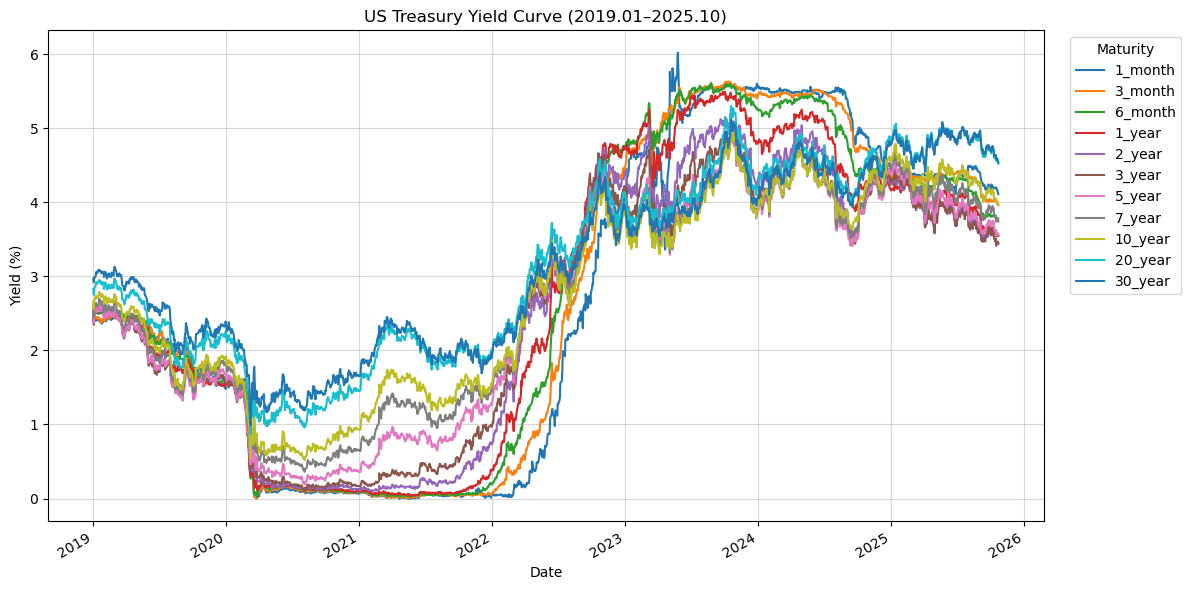

In [50]:
plt.figure(figsize=(12, 6))

# Plot all columns of the DataFrame
yield_df_cleaned.plot(ax=plt.gca(), legend=False)

plt.title('US Treasury Yield Curve (2019.01–2025.10)')
plt.xlabel('Date')
plt.ylabel('Yield (%)')

# Add a legend outside the plot area
plt.legend(title="Maturity", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

Decompose by short, medium, and long term

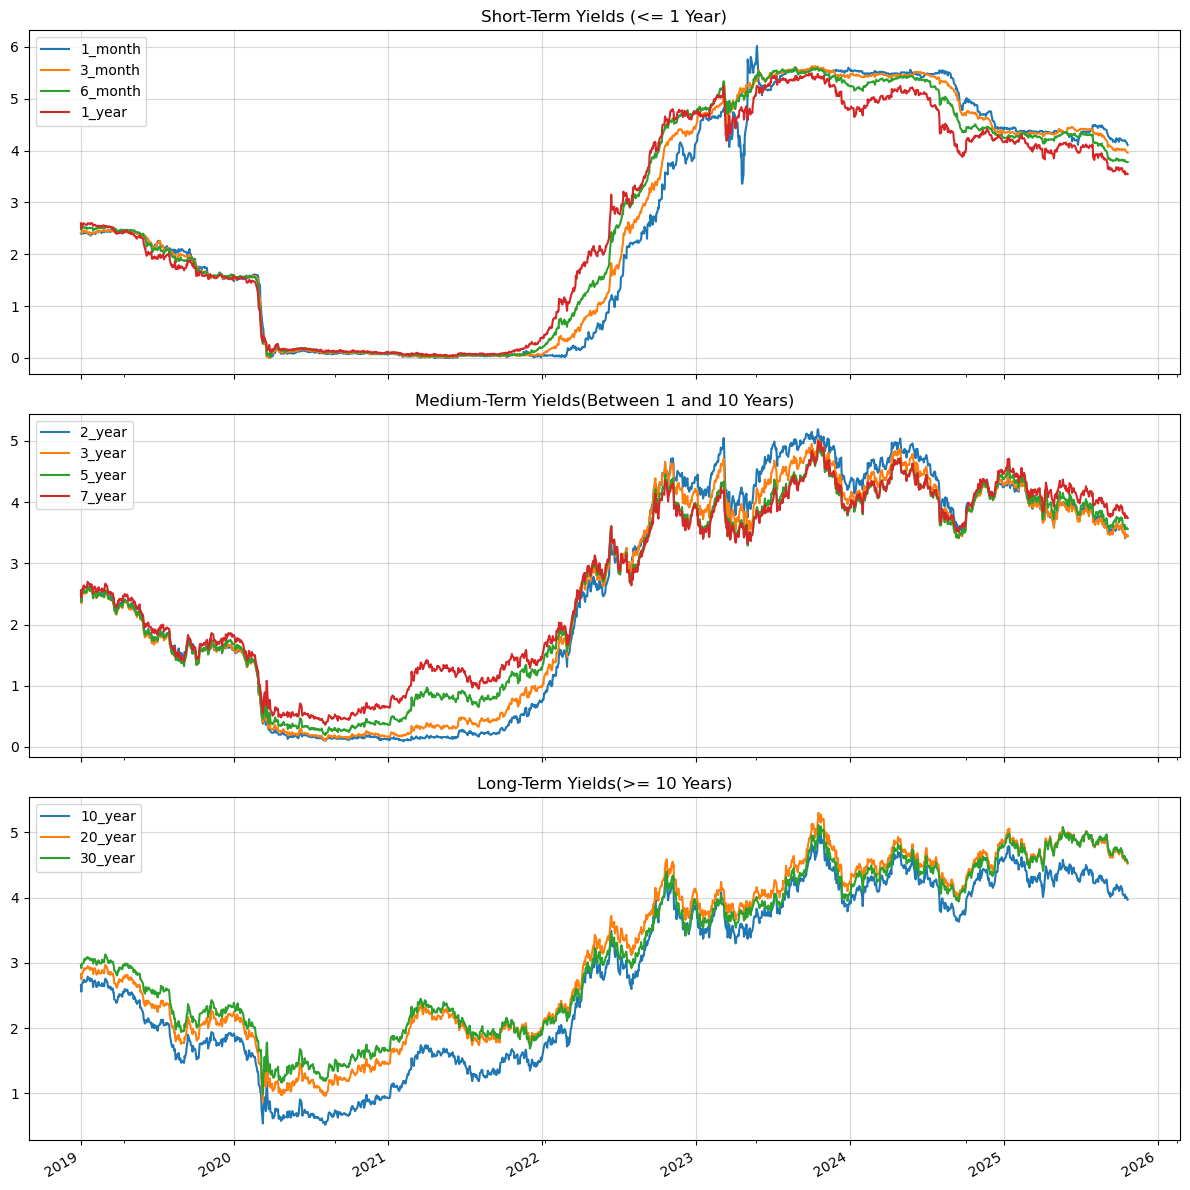

In [134]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Plot 1: Short-Term
yield_df_cleaned[['1_month', '3_month', '6_month', '1_year']].plot(ax=axes[0])
axes[0].set_title('Short-Term Yields (<= 1 Year)')
axes[0].grid(True, alpha=0.5)

# Plot 2: Medium-Term
yield_df_cleaned[['2_year', '3_year', '5_year', '7_year']].plot(ax=axes[1])
axes[1].set_title('Medium-Term Yields(Between 1 and 10 Years)')
axes[1].grid(True, alpha=0.5)

# Plot 3: Long-Term
yield_df_cleaned[['10_year', '20_year', '30_year']].plot(ax=axes[2], title='Long-Term Yields')
axes[2].set_title('Long-Term Yields(>= 10 Years)')
axes[2].grid(True, alpha=0.5)

# Adjust layout and show one unified legend
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

#### U.S. Treasury Yield Curve Summary: 2019 – Oct 2025

The period from 2019 to late 2025 saw the yield curve traverse three distinct regimes: a pre-COVID flat curve, an extreme post-COVID steepening, and a deep, prolonged inversion driven by aggressive Federal Reserve tightening.

---

##### 1. Short-Term Yields (1-Month to 1-Year) 

This segment is the **most volatile**, driven primarily by the **Federal Reserve's policy rate** (Fed Funds Rate) and near-term market expectations.

* **2019 – Early 2020:** Short rates were relatively high/flat, reflecting an aging economic cycle.
* **March 2020:** Rates **plummeted instantly to the Zero Lower Bound (ZLB)** in response to the COVID-19 shock.
* **Late 2021 – Oct 2025:** Experienced a **rapid, sustained ascent** due to the aggressive rate hikes aimed at combating surging inflation. Short rates became the **highest point on the curve** throughout 2023–2025.

---

##### 2. Medium-Term Yields (2-Year to 7-Year) 
This segment reflects the market's **median forecast** for the path of interest rates and inflation over the medium term.

* **2020 – Early 2022:** Rates rose significantly faster than the ZLB-pinned short rates, creating a dramatically **steep curve** on recovery hopes.
* **2022 – Oct 2025:** Entered a phase of **deepest inversion**. The 2-Year rate, in particular, often surpassed the 10-Year yield by the largest margin, signaling strong market conviction that the Fed would eventually be forced to **cut rates** (recession fears).

---

##### 3. Long-Term Yields (10-Year to 30-Year) 

This segment is the **most stable**, reflecting long-term factors like **structural inflation** and **long-term GDP growth potential**.

* **2019 – 2020:** Rates were low and stable, reflecting subdued long-run inflation expectations.
* **2022 – Oct 2025:** Rates settled at a structurally **higher level** (e.g., $4-5\%$) than the previous decade. This confirmed a market belief in a "**higher-for-longer**" interest rate environment, even while inverted against short-term rates.

---

### 5.3 Treasury Yield Curve Change Overtime  <a class="anchor" id="5c"></a>

Understanding non-parallel yield curve movements—captured by the Slope and Curvature factors—is crucial because assuming only parallel shifts will inevitably lead to incorrect pricing and inaccurate hedging of fixed-income assets. A portfolio hedged only against Level risk (parallel moves) is exposed to significant losses when the curve flattens, steepens, twist, bumps or humps, as different bond maturities react with different sensitivities. Accurately modeling these non-parallel shifts is therefore essential for mitigating basis risk and achieving correct portfolio valuation and liability matching.

This section explores the necessity of factor modeling by visually analyzing the U.S. Treasury yield curve's evolution from January 2019 to October 2025.

In [184]:
# --- 1. Define Maturities (True Time Ratio) ---
# The dictionary uses actual time ratios for X-axis positioning
maturity_map = {
    '1_month': 1/12, '3_month': 3/12, '6_month': 6/12, 
    '1_year': 1, '2_year': 2, '3_year': 3, '5_year': 5, 
    '7_year': 7, '10_year': 10, '20_year': 20, '30_year': 30
}
maturity_labels = list(maturity_map.keys())


# --- 2. Create Custom Staggered Tick Labels ---
# This ensures short-term labels don't overlap on the true time-ratio scale.
tick_positions = list(maturity_map.values())
custom_tick_text = []

for label in maturity_labels:
    if label == '3_month':
        custom_tick_text.append('') # HIDE 3_month label
    elif label in ['1_month', '6_month', '2_year', '7_year']:
        custom_tick_text.append(f"{label}<br>") # Staggered (upper) row
    else:
        custom_tick_text.append(label) # Standard (lower) row


# --- 3. Reshape the Data for Plotly (Long Format) ---
# Prepare the data for Plotly's animation frame.

df_plot_working = yield_df_cleaned.copy() 

# FIX 1: Format the index to YYYY-MM-DD string for a clean slider
df_plot_working.index = df_plot_working.index.strftime('%Y-%m-%d') 

# Rename columns (Maturity names to numerical time)
df_plot_working = df_plot_working.rename(columns=maturity_map)

# Melt the data from wide to long format
df_long = df_plot_working.reset_index().melt(
    id_vars='index',
    var_name='Maturity_Time', # Actual time ratio is the X data
    value_name='Yield'
).rename(columns={'index': 'Date'})


# --- 4. Create Interactive Plotly Figure ---

fig = px.line(
    df_long,
    x='Maturity_Time',
    y='Yield',
    animation_frame='Date', # Uses the clean date string
    line_group='Date', 
    markers=True,
    title='U.S. Treasury Yield Curve Evolution (2019-01 To 2025-10)'
)


# --- 5. Customizing the Plot ---

# FIX 2: Set the plot width (1000px) and bottom margin (180px)
fig.update_layout(
    width=1000,
    margin=dict(l=40, r=40, t=80, b=180), 
    title_x=0.5
)

# FIX 3: Configure the X-axis for staggered, angled labels (hiding 3_month)
fig.update_xaxes(
    tickvals=tick_positions,
    ticktext=custom_tick_text, 
    title_text=None, # Hide "Maturity" label
    tickangle=-45,
    automargin=False
)

# FIX 4: Set Y-axis range from 0 to 6.5
fig.update_yaxes(
    range=[0, 6.5],
    title_text='Yield (%)'
)

# Customizing trace appearance and hover template
fig.update_traces(
    line=dict(color='blue', width=3),
    hovertemplate="<b>Date: %{customdata[0]}</b><br>" + 
                  "Yield: %{y:.2f}%<extra></extra>",
    customdata=df_long[['Date']] 
)

# Set animation speed
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 50 
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 20

fig.show()

Yield Curve Dynamics (January 2019 – October 2025): Observation of the Treasury yield curve across this period clearly demonstrates that non-parallel shifts have been the dominant feature, driven primarily by the Federal Reserve's aggressive policy responses to the COVID-19 shock and subsequent inflation surge. The curve underwent several major regime changes—from mild inversion to extreme steepening and deep inversion—which underscore why factor models (Level, Slope, Curvature) are essential for accurately managing fixed-income risk. Here are the key takeaways from this volatile period:

1. 2019.01–2020.02 (Stable and Slightly Flattening):Observation: Generally higher short-term Fed funds expectations early in 2019, with some curvature changes mid‑year—mid‑term yields (around 2–5 years) flattened or dipped relative to short and long yields.
<br>Reasoning: Market priced in slower growth and potential Fed easing after 2019 growth/ trade‑tension worries; inversion/flattening reflects recession risk priced into intermediate maturities.
<br>
<br>
2. 2020.03–2021.12 (Sharp Downward Shift and Steepening):Observation: March 2020 saw an abrupt, mostly parallel downward shift as the Fed cut rates toward zero and injected liquidity; from late‑2020 into 2021 the curve steepened (short stays low, medium/long rise).
<br>Reasoning: Fed emergency easing and forward guidance pushed short rates to the effective lower bound (parallel drop). Economic recovery expectations, fiscal stimulus, and rising inflation/real rate expectations pushed medium/long yields back up, creating steepening (non‑parallel).
<br>
<br>
3. 2022.01–2022.10 (Rapid Upward Shift and Concavity Increase):Observation: Large upward shift in yields across the curve, combined with non‑parallel moves: medium term (1–5y) rose especially strongly, increasing concavity (more pronounced hump).
<br>Reasoning: Rapid Fed tightening to combat high inflation (rate hikes and signaling of aggressive hikes) raised near‑term policy expectations and term premia. Stronger moves in 1–5y reflect the market re‑pricing of policy path + rising real rates and inflation breakevens.
<br>
<br>
4. 2022.11–2023.05 (Persistently Inverted Curve):Movement: Observation: Curve shape changed — short rates remained high while medium/long yields moved more variably; the curve flattened and in parts inverted.
<br>Reasoning: As policy tightening continued, markets increasingly priced a higher probability of slower growth/recession later, which pushed longer yields down relative to short yields (inversion/flattening). Term premium adjustments and demand for long-duration safe assets also contributed.
<br>
<br>
5. 2023.05–2024.08 (Partial Curve Reversal):Observation: The curve stayed inverted for much of this period. There were episodes of flattening and temporary steepening, but short-term yields remained elevated.
<br>Reasoning: Uncertainty over inflation persistence and the timing of the Fed's pivot. Volatility was driven by economic data signaling either more hikes (flattening) or coming cuts (steepening).
<br>
<br>
6. 2024.09–2025.10 (Steepening Out of Inversion):Observation: Non-parallel shift where the inversion began to unwind (Slope approaches zero or positive). Medium/long-term yields experienced significant movement relative to the short end.
<br>Reasoning: The market starts pricing in a combination of Fed rate cuts (pulling the short end down) and/or a return to long-term growth and a higher inflation premium (pushing the long end up). This is a common end-of-cycle steepening signal.


---


### 5.4 Correlation Heatmap (Correlation between different term yields) <a class="anchor" id="5d"></a>

Correlation matrix and heatmap for the daily changes in yields of the 11 maturities help understand the parallel and non-parallel shift among different terms.
Insight: 
- High correlation between all yields (e.g. 1 month, 1 year, 10 year) suggests parallel shifts dominate. 
- Lower correlation between the short end and the long end is evidence of non-parallel movement (flattening/steepening or curvature change).

In [235]:
#  Define the Regimes based on previous analysis
regime_dates = {
    '1. Stable/Flattening (2019.01–2020.02)': ('2019-01-01', '2020-02-29'),
    '2. Downward Shift/Steepening (2020.03–2021.12)': ('2020-03-01', '2021-12-31'),
    '3. Upward Shift/Concavity (2022.01–2022.10)': ('2022-01-01', '2022-10-31'),
    '4. Persistently Inverted (2022.11–2023.05)': ('2022-11-01', '2023-05-31'),
    '5. Partial Reversal (2023.05–2024.08)': ('2023-06-01', '2024-08-31'),
    '6. Steepening Out (2024.09–2025.10)': ('2024-09-01', '2025-10-22') 
}

Correlation of Daily Changes in Yields vs. Correlation of Yields

- Using the correlation of the differences (i.e., yield changes or returns) helps understand the dynamic relationships—how yields at different maturities move relative to each other over time. This approach emphasizes co-movements in yield fluctuations, which are generally more stationary and easier to interpret economically.

- Using the correlation among the raw yields (levels) focuses on the static relationships—whether yields at different maturities tend to move together in the same direction or are influenced by common factors at the same point in time.

Since our goal is to analyze non-parallel movements rather than parallel shifts, we are primarily interested in how the shape of the yield curve evolves over time. Therefore, it is more appropriate to examine the correlation of yield changes (differences), as this captures the dynamic co-movements related to slope and curvature adjustments, providing deeper insights into non-parallel variations.

In [240]:
# Calculate Daily Changes in yields
# Drop the first row one with missing values
yield_changes = yield_df_cleaned.diff().dropna()

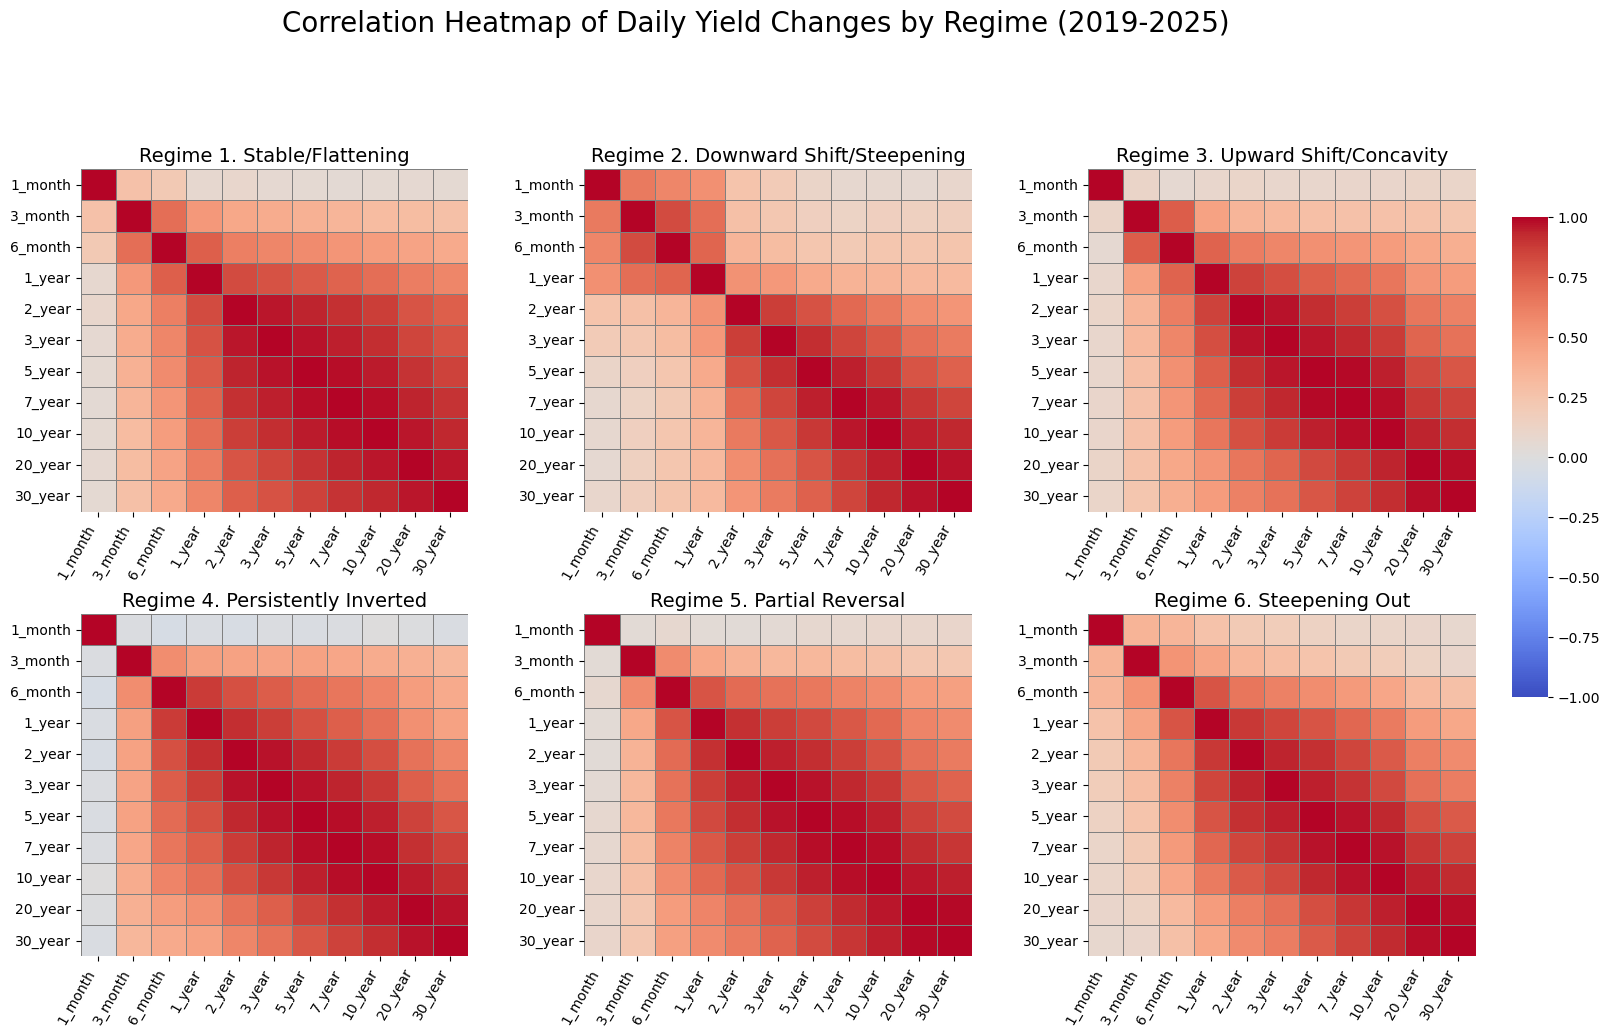

In [251]:
# Set up the figure and axes for subplots with a shared colorbar

# List of regime names
years = list(regime_dates.keys())
# Total number of regimes to plot
num_plots = len(years)

# Create a figure with specified size
fig = plt.figure(figsize=(18, 16))
# Set up a 3x3 grid of subplots using GridSpec for flexible layout
# right=0.9 leaves space on the right for the colorbar
gs = GridSpec(3, 3, figure=fig, wspace=0.3, hspace=0.3, right=0.9)

# Initialize list to hold axes
axes = []
for i in range(9):
    if i < num_plots:
        # Create subplot in the grid for each regime
        axes.append(fig.add_subplot(gs[i]))
    else:
        # For unused cells, create invisible axes to keep layout consistent
        axes.append(fig.add_subplot(gs[i], visible=False))

# Define a single axes for the shared colorbar, positioned on the right side
# [left, bottom, width, height]; narrow width and adjust height as needed
cbar_ax = fig.add_axes([0.92, 0.55, 0.02, 0.3]) 

# Loop through each regime to calculate and plot the correlation heatmap
for i, (title, (start_date, end_date)) in enumerate(regime_dates.items()):
    ax = axes[i]
    
    # Extract yield changes within the current regime period
    regime_data = yield_changes.loc[start_date:end_date]
    
    # Compute the correlation matrix of yield changes for the regime
    regime_corr = regime_data.corr()
    
    # Plot the correlation matrix as a heatmap
    sns.heatmap(
        regime_corr, 
        annot=False,
        fmt=".2f",
        cmap='coolwarm',
        linewidths=0.5,
        linecolor='grey',
        vmin=-1.0,  
        vmax=1.0,
        ax=ax,
        # Show the colorbar only on the first subplot and link it to cbar_ax
        cbar=(i == 0),
        cbar_ax=cbar_ax if i == 0 else None
    )
    
    ax.set_title(f"Regime {title.split('(')[0].strip()}", fontsize=14)
    ax.set_yticklabels(ax.get_yticklabels())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')

# Remove any unused subplots from the layout
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

# Add overall title for the entire figure
plt.suptitle('Correlation Heatmap of Daily Yield Changes by Regime (2019-2025)', fontsize=20)
plt.show()

- Insights:
1. In all of the plots we can see that the daily changes in yields has a stronger correlation with maturities greater than 2 years. This intuitionally makes sense as the short term market (yields under 2 years) mostly reflect the market predictions in Fed's immediate interest rate movement while the long term reflects more on the economic growth, structural inflation, and medium terms is a blend of short and long term.

2. The exceptionally strong correlation among short-term Treasury yields ($1\text{M}$ to $1\text{Y}$) in regime 2 from March 2020 to December 2021 was due to the Fed's total control of the short-term market. After cutting the Federal Funds Rate (FFR) to near zero ($0\%-0.25\%$) in March 2020, the Fed used explicit promises ("lower for longer") and massive bond buying (QE) to effectively peg all short-term rates. This meant all short-term instruments were priced almost identically as they all reflected the same near-zero policy rate, forcing their daily movements to be highly synchronized (correlation near $+1.0$).

---

### 5.5 Slope and Curvature Change  <a class="anchor" id="5e"></a>

Yield Curve Factor Proxies: 

Slope and CurvatureA non-parallel yield curve change can usually be decomposed by two main factors: a slope change or a curvature change. Even though a yield curve is not a straight line, we can still use the difference between the 10-year yield and the 2-year yield as a good approximation of the slope, as these two are representative benchmarks for the short and long ends of the curve.

To show the curvature change, we use the Butterfly Spread as a proxy: the 5-Year yield minus the average of the 2-Year and 10-Year yields. If the curve becomes more concave (humped), the 5-year yield will be higher than the average, resulting in a positive curvature value ($Y_{5Y} > \frac{Y_{2Y} + Y_{10Y}}{2}$). Conversely, if the curve becomes more convex (bowed), the 5-year yield will be lower than the average, resulting in a negative curvature value.

To visualize the change in these non-Level factors, we will use:

Slope: $Y_{10Y} - Y_{2Y}$   When slope > 0: upward yield curve/normal curve; when slope<0: inverted yield curve

Curvature: $Y_{5Y} - \frac{Y_{2Y} + Y_{10Y}}{2}$

In [253]:
# Calculate Slope Proxy: 10-Year minus 2-Year 
df_slope = yield_df_cleaned['10_year'] - yield_df_cleaned['2_year']
df_slope.name = 'Slope (10Y - 2Y Spread)'

In [254]:
# Calculate Curvature Proxy (Butterfly Spread): 5Y minus Average of 2Y and 10Y
df_curvature = yield_df_cleaned['5_year'] - (yield_df_cleaned['2_year'] + yield_df_cleaned['10_year']) / 2
df_curvature.name = 'Curvature (5Y - Avg(2Y, 10Y))'

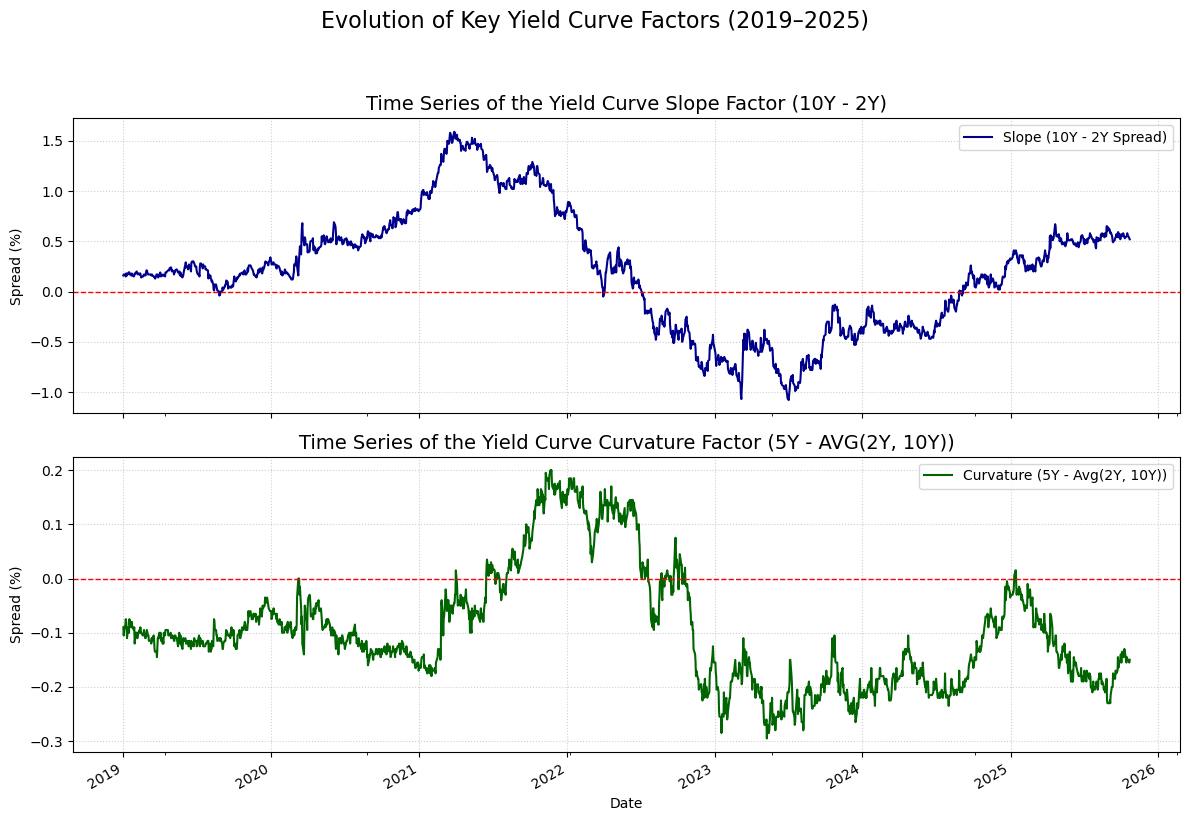

In [258]:
#  Plot Time Series
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# --- Slope Plot ---
df_slope.plot(ax=axes[0], color='darkblue', linewidth=1.5)
axes[0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0].set_title('Time Series of the Yield Curve Slope Factor (10Y - 2Y)', fontsize=14)
axes[0].set_ylabel('Spread (%)')
axes[0].grid(True, linestyle=':', alpha=0.6)
axes[0].legend()

# --- Curvature Plot ---
df_curvature.plot(ax=axes[1], color='darkgreen', linewidth=1.5)
axes[1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1].set_title('Time Series of the Yield Curve Curvature Factor (5Y - AVG(2Y, 10Y))', fontsize=14)
axes[1].set_ylabel('Spread (%)')
axes[1].set_xlabel('Date')
axes[1].grid(True, linestyle=':', alpha=0.6)
axes[1].legend()

plt.suptitle('Evolution of Key Yield Curve Factors (2019–2025)', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

- Insights:
1. Slope Analysis: $10\text{Y} - 2\text{Y}$ Spread

    The slope of the yield curve underwent a complete cycle from steepening to inversion and back. From 2019 through the beginning of 2021, the curve was generally upward-sloping and began to steepen as the economy recovered from the pandemic and investors priced in rising inflation expectations. This was driven by the long-term ($10\text{Y}$) rate increasing while the Federal Reserve kept the short-term ($2\text{Y}$) rate anchored near zero. This trend dramatically reversed from late 2021 into 2023, where aggressive rate hikes by the Fed to fight inflation caused the short-term rate to rapidly surge, resulting in the curve flattening and then inverting. The $2\text{Y}$ rate surpassed the $10\text{Y}$ rate because the market anticipated that the tightening cycle would trigger a recession and necessitate future rate cuts. Since 2024, the curve has begun to re-steepen as the $2\text{Y}$ yield falls faster in expectation of rate cuts, though persistent inflation concerns are preventing the $10\text{Y}$ yield from falling significantly, leaving the upward slope somewhat static and moderate.

2. Curvature: (5Y - AVG(2Y, 10Y)) 

    The difference can gives us some intuition on the curvature change across different regimes from 2019 to 2025. Starting from 2021, the concern in Fed raising interest rate caused the yield curve to be more concave, causing the mid term rates to rise more sharply. From 2022 to 2023, the aggresive interest rate hike caused the short term(2 Year) to rise at a higher rate than intermediate and long term rate, causing the yield curve between 2Y and 10Y to become covex. This approach is not very precise in reflecting the curvature movements after 2024, a better approximation should be using the mathematical approximation using the second derivatves .

---

## 6. Data Export <a class="anchor" id="6"></a>

In [260]:
# Export the data
yield_df_cleaned.to_csv("../data/yield_cleaned.csv")